In [1]:
import pandas as pd
import numpy as np
from time import time
#visualization
import seaborn as sns
from matplotlib import pyplot as plt
#models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#sklearn stuff
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,precision_recall_curve, f1_score, auc
#tree / forest stuff
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
#imblearn stuff
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
#warnings
import warnings
warnings.filterwarnings("ignore") # this will take away the red dialog boxes in the output terminal

In [2]:
X_train = pd.read_csv("../Data/TrainTest/X_train.csv")
X_test = pd.read_csv("../Data/TrainTest/X_test.csv")
y_train = pd.read_csv("../Data/TrainTest/y_train.csv")
y_test = pd.read_csv("../Data/TrainTest/y_test.csv")

In [3]:
print(sum(y_train['Attrition_Yes'])/len(y_train))
print(sum(y_test['Attrition_Yes'])/len(y_test))

0.16229348882410108
0.15873015873015872


In [4]:
perc_y = sum(y_train['Attrition_Yes'])/len(y_train)
(1-perc_y)/perc_y
#Anomoly detection algorithm


5.161676646706586

In [5]:
# Get Metrics on models

In [6]:
def get_maxtrix_report(model,X_test,y_test):
    y_pred = model.predict(X_test)
    
    con_mat = confusion_matrix(y_test,y_pred)
    sns.heatmap(con_mat,cmap='Blues',annot=True,fmt='d')
    plt.show()
    class_report = classification_report(y_test,y_pred,target_names=['Attrition_False','Attrition_True'])
    print(class_report)
    return con_mat, class_report

In [7]:
def run_suite(model_name,smote=True,rs=42,folds=5,scoring='f1'): #scoring on f1 for harmonic mean fo the model
    
    model = model_dict[model_name]['Model']
    
    if smote:
        pipeline = make_pipeline(SMOTE(random_state=rs),model)
        params = model_dict[model_name]['params']
        params = {model_name+"__"+p:params[p] for p in params}
    else:    
        pipeline = model
        params = model_dict[model_name]['params']
        
    cv = GridSearchCV(pipeline,
                             param_grid=params,
                             cv=KFold(n_splits=folds, random_state=rs, shuffle=True),
                             scoring=scoring,
                             return_train_score=True,
                             n_jobs=-1,
                             verbose=True)
    
    cv.fit(X_train,y_train)
    best_e = cv.best_estimator_
    
    _,_ = get_maxtrix_report(best_e,X_test,y_test)
    if smote:
        return best_e[model_name]
    else:
        return best_e

In [ ]:
def graph_prec_rec_curve(model_names,X_test,y_test):
    # predict probabilities # keep probabilities for the positive outcome only
    for i, model_name in enumerate(model_names):
        model = best[model_name]
        model_probs =model.predict_proba(X_test)[:, 1]
        # predict class values
        yhat = model.predict(X_test)
        model_precision, model_recall, _ = precision_recall_curve(y_test["Attrition_Yes"], model_probs)
        model_f1 = f1_score(y_test["Attrition_Yes"], yhat)
        model_auc= auc(model_recall, model_precision)
        # summarize scores
        print(model_name,'f1=%.3f auc=%.3f' % (model_f1, model_auc))
        # plot the precision-recall curves
        
        style = {0:("-","r"),
                    1:(":","b"),
                    2:("--","k")}
        
        marker,color = style[i]
        plt.plot(model_recall, model_precision, linestyle=marker,color=color,label=model_name)
    
    no_skill = sum(y_test["Attrition_Yes"])/ len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='-',color="y",label='No Skill')
    # axis labels
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

models = ['Smote_XGBC','XGBC','LogReg']
graph_prec_rec_curve(models,X_test,y_test)

In [13]:
model_dict = {'randomforestclassifier':
                {'Model':RandomForestClassifier(),
                'params':{'n_estimators':list(range(10,121,10)),
                          #'criterion':['gini','entropy'],
                           #     'max_depth':[2,3,4,5,None],
                                'max_features':['sqrt','log2',10]}}}

model_dict['kneighborsclassifier']={'Model':KNeighborsClassifier(),
               'params':{'p':[1,2],
                    'weights':['uniform','distance'],
                    'n_neighbors':list(range(3,10,2))}}


model_dict['logisticregression']={'Model':LogisticRegression(),
               'params':{'penalty':['l2','l1',None,'elasticnet']}}

model_dict['xgbclassifier']={'Model':XGBClassifier(),
               'params':{'learning_rate':np.arange(.1,.5,.1),
                         'max_depth':[3,4,5,"None"],
                         'scale_pos_weight':[5],
                         'n_estimators':np.arange(60,151,10)
                        }}


In [14]:
best = {} #best_models

# XGBoost

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[17:11:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


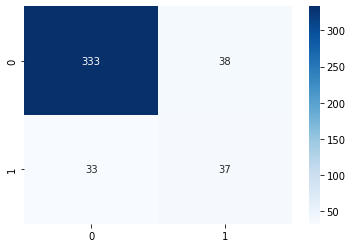

                 precision    recall  f1-score   support

Attrition_False       0.91      0.90      0.90       371
 Attrition_True       0.49      0.53      0.51        70

       accuracy                           0.84       441
      macro avg       0.70      0.71      0.71       441
   weighted avg       0.84      0.84      0.84       441

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[17:12:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


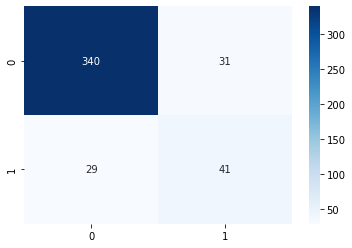

                 precision    recall  f1-score   support

Attrition_False       0.92      0.92      0.92       371
 Attrition_True       0.57      0.59      0.58        70

       accuracy                           0.86       441
      macro avg       0.75      0.75      0.75       441
   weighted avg       0.87      0.86      0.86       441



In [15]:
best['XGBC'] = run_suite('xgbclassifier',smote=False)
best['Smote_XGBC'] = run_suite('xgbclassifier',smote=True)

<AxesSubplot:>

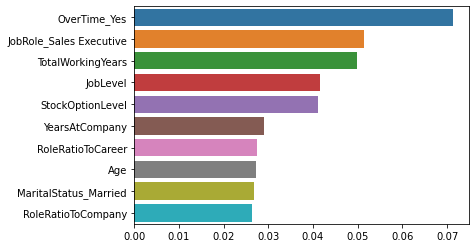

In [16]:
feature_rank = pd.Series(best['XGBC'].feature_importances_,index=X_train.columns).sort_values(ascending=False)
top_10 = feature_rank.head(10)
sns.barplot(top_10,top_10.index)

<AxesSubplot:>

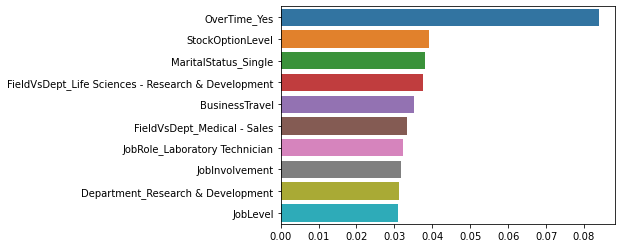

In [17]:
feature_rank = pd.Series(best['Smote_XGBC'].feature_importances_,index=X_train.columns).sort_values(ascending=False)
top_10 = feature_rank.head(10)
sns.barplot(top_10,top_10.index)

In [18]:
best['Smote_XGBC']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=110, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
best['XGBC']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# K-Nearest neighbor

Fitting 5 folds for each of 16 candidates, totalling 80 fits


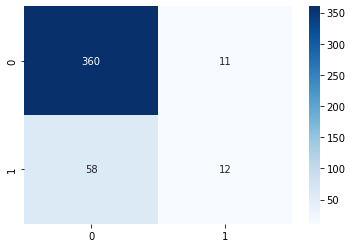

                 precision    recall  f1-score   support

Attrition_False       0.86      0.97      0.91       371
 Attrition_True       0.52      0.17      0.26        70

       accuracy                           0.84       441
      macro avg       0.69      0.57      0.59       441
   weighted avg       0.81      0.84      0.81       441

Fitting 5 folds for each of 16 candidates, totalling 80 fits


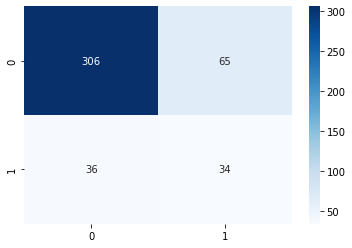

                 precision    recall  f1-score   support

Attrition_False       0.89      0.82      0.86       371
 Attrition_True       0.34      0.49      0.40        70

       accuracy                           0.77       441
      macro avg       0.62      0.66      0.63       441
   weighted avg       0.81      0.77      0.79       441



In [20]:
best['KNN'] = run_suite('kneighborsclassifier',smote=False)
best['Smote_KNN'] = run_suite('kneighborsclassifier',smote=True)

# Logistic Regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits


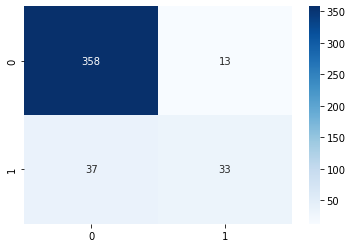

                 precision    recall  f1-score   support

Attrition_False       0.91      0.96      0.93       371
 Attrition_True       0.72      0.47      0.57        70

       accuracy                           0.89       441
      macro avg       0.81      0.72      0.75       441
   weighted avg       0.88      0.89      0.88       441

Fitting 5 folds for each of 4 candidates, totalling 20 fits


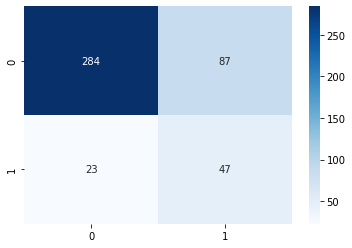

                 precision    recall  f1-score   support

Attrition_False       0.93      0.77      0.84       371
 Attrition_True       0.35      0.67      0.46        70

       accuracy                           0.75       441
      macro avg       0.64      0.72      0.65       441
   weighted avg       0.83      0.75      0.78       441



In [21]:
best['LogReg'] = run_suite('logisticregression',smote=False)
best['Smote_LogReg'] = run_suite('logisticregression',smote=True)

<AxesSubplot:>

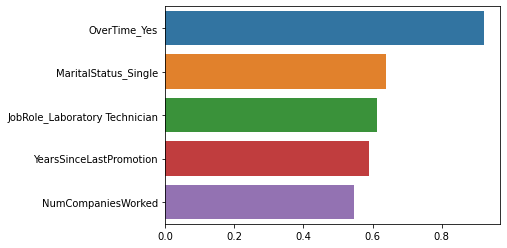

In [22]:
feature_rank = pd.Series(best['LogReg'].coef_[0],index=X_train.columns).sort_values(ascending=False)
top_10 = feature_rank.head(5)
sns.barplot(top_10,top_10.index)

<AxesSubplot:>

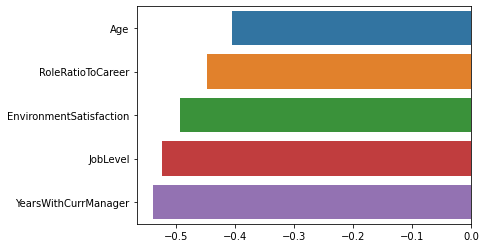

In [23]:
feature_rank = pd.Series(best['LogReg'].coef_[0],index=X_train.columns).sort_values(ascending=False)
top_10 = feature_rank.tail()
sns.barplot(top_10,top_10.index)

In [24]:
pd.Series(best['LogReg'].coef_[0],index=X_train.columns).to_frame()

,0
Age,-0.403923
BusinessTravel,0.520546
DailyRate,-0.149493
DistanceFromHome,0.331032
Education,0.028942
...,...
FieldVsDept_Other - Research & Development,0.033552
FieldVsDept_Other - Sales,0.114528
FieldVsDept_Technical Degree - Human Resources,0.087908
FieldVsDept_Technical Degree - Research & Development,0.104738


<AxesSubplot:>

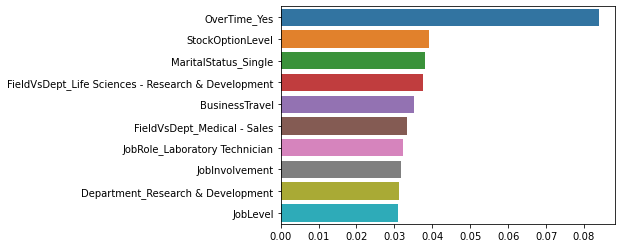

In [25]:
feature_rank = pd.Series(best['Smote_XGBC'].feature_importances_,index=X_train.columns).sort_values(ascending=False)
top_10 = feature_rank.head(10)
sns.barplot(top_10,top_10.index)

# Random Forest

Fitting 5 folds for each of 36 candidates, totalling 180 fits


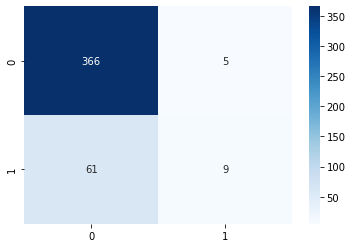

                 precision    recall  f1-score   support

Attrition_False       0.86      0.99      0.92       371
 Attrition_True       0.64      0.13      0.21        70

       accuracy                           0.85       441
      macro avg       0.75      0.56      0.57       441
   weighted avg       0.82      0.85      0.81       441

Fitting 5 folds for each of 36 candidates, totalling 180 fits


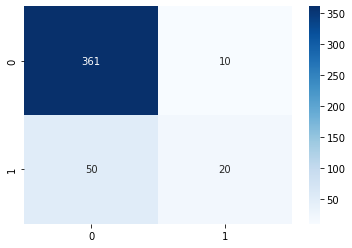

                 precision    recall  f1-score   support

Attrition_False       0.88      0.97      0.92       371
 Attrition_True       0.67      0.29      0.40        70

       accuracy                           0.86       441
      macro avg       0.77      0.63      0.66       441
   weighted avg       0.84      0.86      0.84       441



In [26]:
best['RF'] = run_suite('randomforestclassifier',smote=False)
best['Smote_RF'] = run_suite('randomforestclassifier',smote=True)

<AxesSubplot:>

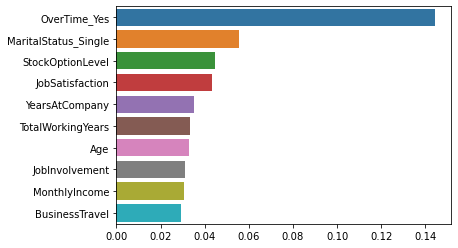

In [27]:
feature_rank = pd.Series(best['Smote_RF'].feature_importances_,index=X_train.columns).sort_values(ascending=False)
top_10 = feature_rank.head(10)
sns.barplot(top_10,top_10.index)

<AxesSubplot:>

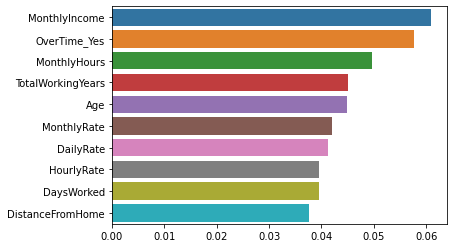

In [28]:
feature_rank = pd.Series(best['RF'].feature_importances_,index=X_train.columns).sort_values(ascending=False)
top_10 = feature_rank.head(10)
sns.barplot(top_10,top_10.index)

### Predictive Model